In [23]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [24]:
data = np.loadtxt('../data/concrete.txt',dtype=np.float32)
np.random.shuffle(data)

cutoff = int(len(data)*0.8)
X_train, Y_train  = data[:cutoff, :-1], data[:cutoff, -1]
X_test, Y_test = data[cutoff:, :-1], data[cutoff:, -1]

std_X_train = np.std(X_train, 0)
mean_X_train = np.mean(X_train, 0)

X_train_norm = (X_train - mean_X_train) / std_X_train
X_test_norm  = (X_test - mean_X_train) / std_X_train

mean_Y_train = np.mean(Y_train)
std_Y_train = np.std(Y_train)

Y_train_norm = (Y_train - mean_Y_train) / std_Y_train
Y_train_norm = np.array(Y_train_norm, ndmin = 2).T

Y_test_norm = (Y_test - mean_Y_train) / std_Y_train
Y_test_norm = np.array(Y_test_norm, ndmin = 2).T

In [25]:
model_params = {"learning_rate": 0.001,
                "dropout": 0.01,
                "hidden_width": 100,
                "batch_size": 32,
                "n_epoch": 40}

In [26]:
X_train_tensor = torch.from_numpy(X_train_norm)
Y_train_tensor = torch.from_numpy(Y_train)
X_test_tensor  = torch.from_numpy(X_test_norm)
Y_test_tensor  = torch.from_numpy(Y_test)

train_tensor_dataset = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
test_tensor_dataset  = torch.utils.data.TensorDataset(X_test_tensor, Y_test_tensor)

data_loader_train = torch.utils.data.DataLoader(dataset=train_tensor_dataset, 
                                          batch_size=128, 
                                          shuffle=True,
                                          num_workers=4)

data_loader_test = torch.utils.data.DataLoader(dataset=test_tensor_dataset, 
                                          batch_size=128, 
                                          shuffle=False,
                                          num_workers=4)

In [27]:
# Neural Network Model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = F.dropout(x, p=0.01, training=True)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.01, training=True)
        x = self.fc2(x)
        return x

In [28]:
model = Net(input_size=8, hidden_size=500, output_size=1)

optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01,
                            weight_decay=1.0778889384649698e-06,
                            momentum=0.9)

loss_criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [29]:
train_loss = []
test_loss  = []

# Train the Model
for epoch in range(40):
    #print(f'Epoch {epoch}/40')
    
    #train
    batchloss_train = []
    for batch_index, (X_train, Y_train) in enumerate(data_loader_train):  
        # Convert torch tensor to Variable
        X_train_tensor = Variable(X_train).float()
        Y_train_tensor = Variable(Y_train).float()
        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        predicted_Y = model(X_train_tensor)
        trainloss = loss_criterion(predicted_Y, Y_train_tensor)
        trainloss.backward()
        optimizer.step()
        batchloss_train.append(trainloss.data[0])
        
    scheduler.step()
    train_loss.append(np.mean(batchloss_train))
    
    #Test 
    batchloss_test = []
    for batch_index_test, (X_test, Y_test) in enumerate(data_loader_test):
        X_test_tensor = Variable(X_test).float()
        Y_test_tensor = Variable(Y_test).float()
        
        predicted_Y_test = model(X_test_tensor)
        testloss = loss_criterion(predicted_Y_test, Y_test_tensor)
        batchloss_test.append(testloss.data[0])
        
    test_loss.append(np.mean(batchloss_test))
print('Train RMSE: {}'.format(np.sqrt(train_loss[-1])))
print('Test RMSE: {}'.format(np.sqrt(test_loss[-1])))

Train RMSE: 5.257734867786831
Test RMSE: 5.636474604087596


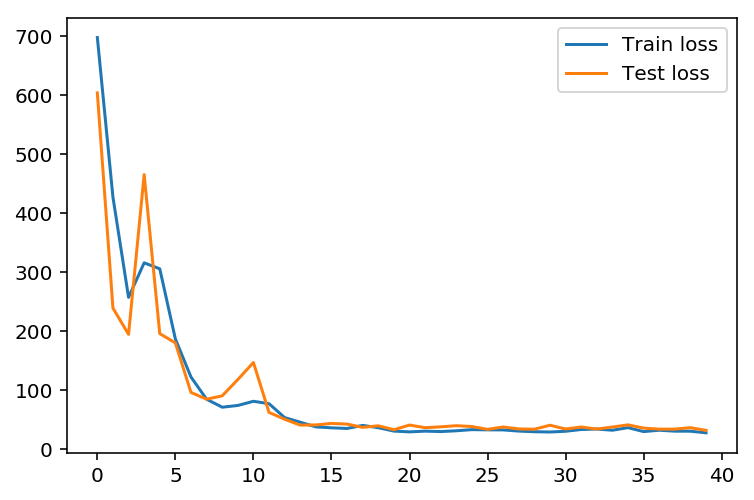

In [30]:
plt.plot(train_loss, label='Train loss')
plt.plot(test_loss, label='Test loss')
#plt.plot(MC_test_loss, label='MC test loss')
plt.legend()

In [34]:
v = []
for _ in range(100):
    v.append( model(torch.from_numpy(X_test_norm[0,:])).data.numpy().item() )
print(Y_test[0])
print(np.mean(v))
print(np.std(v))

10.390000343322754
46.396065406799316
2.1745159338033293


In [35]:
train_loss

[697.4458661760602,
 426.94051688058033,
 257.1427307128906,
 315.6691327776228,
 305.5205775669643,
 186.6625257219587,
 122.17945534842355,
 84.54194368634906,
 71.05850110735211,
 74.0237671988351,
 81.10385731288365,
 77.02288927350726,
 53.48795863560268,
 45.656706128801616,
 37.719987051827566,
 36.13706180027553,
 35.06018284388951,
 40.26824787684849,
 36.309203829084126,
 30.5868535723005,
 29.26876449584961,
 30.496499470302037,
 29.77433477129255,
 31.135861805507115,
 33.05440167018345,
 32.70092909676688,
 32.58587728227888,
 30.569983618600027,
 29.51909283229283,
 29.049907684326172,
 30.296601159232004,
 33.29537827628,
 34.05840138026646,
 32.0617425101144,
 36.417441504342214,
 29.728758675711497,
 32.06312942504883,
 30.45393180847168,
 30.399915967668807,
 27.643775939941406]